In [94]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
from collections import Counter
import pickle

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')

In [3]:
from nltk.corpus import stopwords,wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer


In [4]:
from textblob import TextBlob
from wordcloud import WordCloud

In [5]:
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis

In [6]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel,CoherenceModel

In [38]:
from gensim.models.coherencemodel import CoherenceModel
from itertools import product

In [7]:
df_pre = pd.read_json("Pre_Covid.json")
df_post = pd.read_json("Post_Covid.json")

In [8]:
print(df_pre .shape, df_post.shape)

(60603, 11) (76052, 11)


In [11]:
df_pre = df_pre[['text','created_at']]
df_post = df_post[['text','created_at']]

df_pre['created_at'] = df_pre['created_at'].apply(lambda a: pd.to_datetime(a).to_datetime64())
df_post['created_at'] = df_post['created_at'].apply(lambda a: pd.to_datetime(a).to_datetime64())

In [12]:
print(df_pre.head(5))
print(str(min(df_pre['created_at'])),str(max(df_pre['created_at'])))
print(df_post.head(5))
print(str(min(df_post['created_at'])),str(max(df_post['created_at'])))

                                                text created_at
0  @bel_oubli You need not worry about buying, I ... 2020-03-30
1  @AdminLKO @myogiadityanath @CMOfficeUP @PMOInd... 2020-03-30
2  @Pun_Starr Dont forget tiktok for time pass un... 2020-03-30
3  @bigbasket_com Have you started delivery at 40... 2020-03-30
4  Happy to play and select for lucky draw🤞 in @a... 2020-03-30
2018-07-01 00:00:00 2020-03-30 00:00:00
                                                text created_at
0  @OneTsukuyomi @Flipkart @flipkartsupport I don... 2022-09-24
1  @bennylis @sizzlerbuckie @wba1199 Seriously! I... 2022-09-24
2  @AshwiniKChoubey @PiyushGoyalOffc never ever t... 2022-09-24
3  @Flipkart @flipkartsupport @amazonIN \nStop ma... 2022-09-24
4  @PiyushGoyal @PiyushGoyalOffc dear sir, please... 2022-09-24
2021-01-01 00:00:00 2022-09-24 00:00:00


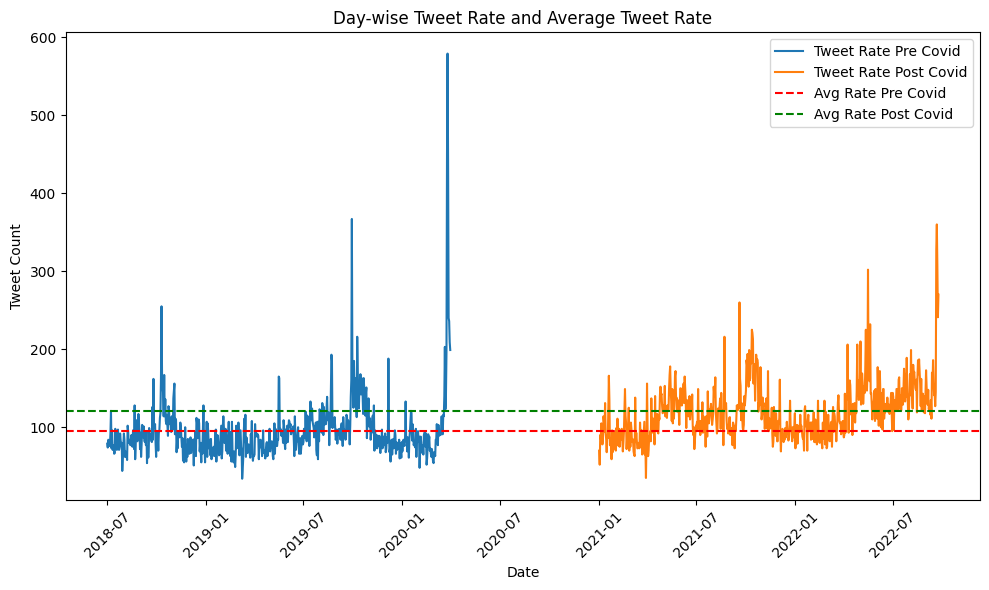

In [13]:
# Group data by date and calculate tweet counts
tweet_counts_pre_covid = df_pre.groupby(df_pre['created_at'].dt.date).size()
tweet_counts_post_covid = df_post.groupby(df_post['created_at'].dt.date).size()

# Calculate average tweet rates for the given date ranges
start_date_pre = pd.to_datetime("2018-07-01").date()
end_date_pre = pd.to_datetime("2020-03-30").date()
average_rate_pre = tweet_counts_pre_covid.loc[start_date_pre:end_date_pre].mean()

start_date_post = pd.to_datetime("2021-01-01").date()
end_date_post = pd.to_datetime("2022-09-24").date()
average_rate_post = tweet_counts_post_covid.loc[start_date_post:end_date_post].mean()

# Plotting
plt.figure(figsize=(10, 6))

# Plotting tweet rates
plt.plot(tweet_counts_pre_covid.index, tweet_counts_pre_covid.values, label='Tweet Rate Pre Covid')
plt.plot(tweet_counts_post_covid.index, tweet_counts_post_covid.values, label='Tweet Rate Post Covid')

# Plotting average tweet rates
plt.axhline(y=average_rate_pre, color='r', linestyle='--', label='Avg Rate Pre Covid')
plt.axhline(y=average_rate_post, color='g', linestyle='--', label='Avg Rate Post Covid')

plt.xlabel('Date')
plt.ylabel('Tweet Count')
plt.title('Day-wise Tweet Rate and Average Tweet Rate')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
def get_wordnet_pos(tag):
    # Map POS tag to WordNet POS tag
    if tag.startswith('J'):
        return 'a'  # Adjective
    elif tag.startswith('V'):
        return 'v'  # Verb
    elif tag.startswith('N'):
        return 'n'  # Noun
    elif tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return 'n'  # Default to Noun

In [15]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [16]:
# Function for preprocessing text
def preprocess(text):
    
    text = remove_emojis(text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'\$\d+(\.\d{1,2})?', '', text)
    
    text = text.lower()
    
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\b\d+\b', '', text)
    
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    
    stop = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop and len(token) > 2]
    tokens = [token for token in tokens if not token.isdigit()]
    
    # POS tagging
    tagged_tokens = TextBlob(' '.join(tokens)).tags
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in tagged_tokens]
    
    return lemmatized_tokens

In [24]:
df_pre['tokens'] =  df_pre['text'].apply(preprocess)
df_post['tokens'] =  df_post['text'].apply(preprocess)

In [25]:
df_pre.to_csv('lemmatized_tokens_pre_covid.csv', index=False)
df_post.to_csv('lemmatized_tokens_post_covid.csv', index=False)

In [27]:
df_pre.head(5)

,text,created_at,tokens
0,"@bel_oubli You need not worry about buying, I ...",2020-03-30,"[need, worry, buy, buy, condom]"
1,@AdminLKO @myogiadityanath @CMOfficeUP @PMOInd...,2020-03-30,"[sir, shop, take, extra, money, every, purchas..."
2,@Pun_Starr Dont forget tiktok for time pass un...,2020-03-30,"[dont, forget, tiktok, time, pas, equipment, d..."
3,@bigbasket_com Have you started delivery at 40...,2020-03-30,"[start, delivery, anushaktinagar, mumbai]"
4,Happy to play and select for lucky draw🤞 in @a...,2020-03-30,"[happy, play, select, lucky, draw, redmi, adua..."


/var/folders/qz/0qg0q3jj3nv9820748j5slf40000gn/T/ipykernel_888/4172551555.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis')
/Users/mousaha/micromamba/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/Users/mousaha/micromamba/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm

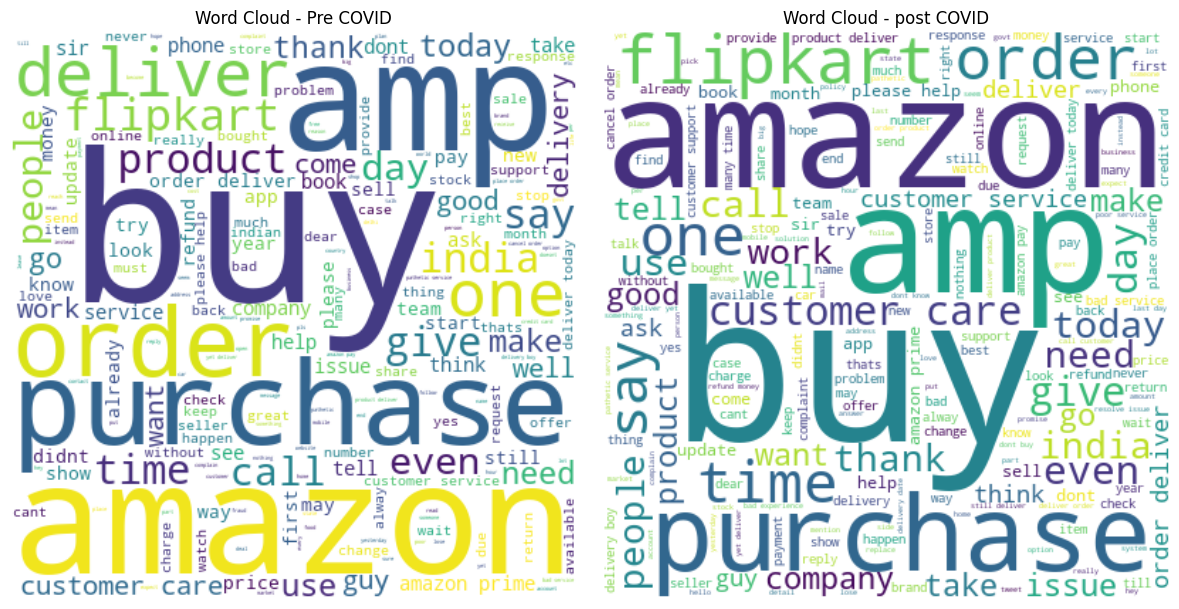

In [33]:
# Drop rows with NaN values in the 'tokens' column for both dataframes
df_pre = df_pre.dropna(subset=['tokens'])
df_post = df_post.dropna(subset=['tokens'])

# Convert tokenized words to strings and create a single string containing all words for both dataframes
all_text_pre = ' '.join(df_pre['tokens'].explode().astype(str))
all_text_post = ' '.join(df_post['tokens'].explode().astype(str))

# Specify colormap using the recommended approach
colormap = cm.get_cmap('viridis')

# Create WordCloud objects for both dataframes
wordcloud_pre = WordCloud(width=400, height=400, background_color='white', colormap=colormap).generate(all_text_pre)
wordcloud_post = WordCloud(width=400, height=400, background_color='white', colormap=colormap).generate(all_text_post)


# Create a side-by-side subplot
plt.figure(figsize=(12, 6))

# Subplot for df_pre
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pre, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Pre COVID')

# Subplot for df_post
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_post, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - post COVID')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [34]:
def lda_params(df):
    # Creating a dictionary to represent the documents.
    dictionary = Dictionary(df['tokens'])

    # Filtering out words that occur less than 5% of the documents, or more than 50% of the documents.
    dictionary.filter_extremes(no_below=int(0.05 * len(df)), no_above=0.5)

    corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

    temp = dictionary[0]
    id2word = dictionary.id2token

    return dictionary,corpus,id2word

In [35]:
dictionary_pre,corpus_pre,id2word_pre = lda_params(df_pre)
dictionary_post,corpus_post,id2word_post = lda_params(df_post)

In [96]:
# Saving preprocessed data
preprocessed_pre_data = {
    'dictionary_pre': dictionary_pre,
    'corpus_pre': corpus_pre,
    'id2word_pre': id2word_pre,
}

with open('preprocessed_data_pre.pkl', 'wb') as f:
    pickle.dump(preprocessed_pre_data, f)

preprocessed_post_data = {
    'dictionary_post': dictionary_post,
    'corpus_post': corpus_post,
    'id2word_post': id2word_post,
}

with open('preprocessed_data_post.pkl', 'wb') as f:
    pickle.dump(preprocessed_post_data, f)

In [100]:
# Loading preprocessed data
with open('preprocessed_data_pre.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# Access loaded data
loaded_dictionary_pre = loaded_data['dictionary_pre']
loaded_corpus_pre = loaded_data['corpus_pre']
loaded_id2word_pre = loaded_data['id2word_pre']

# Loading preprocessed data
with open('preprocessed_data_post.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# Access loaded data
loaded_dictionary_post = loaded_data['dictionary_post']
loaded_corpus_post = loaded_data['corpus_post']
loaded_id2word_post = loaded_data['id2word_post']


In [36]:
def compute_coherence_values(dictionary, corpus, texts, id2word, limit, start=2, step=1):
    coherence_c_v_values = []
    coherence_u_mass_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=id2word,chunksize=1000,   \
                        alpha='auto', eta='auto', \
                        iterations=400, num_topics=num_topics, \
                        passes=20, eval_every=None)
        # model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel_c_v = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherencemodel_u_mass = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        
        coherence_c_v = coherencemodel_c_v.get_coherence()
        coherence_u_mass = coherencemodel_u_mass.get_coherence()
        print(f"Number of Topics: {num_topics}, Coherence Score c_v: {coherence_c_v}")
        print(f"Number of Topics: {num_topics}, Coherence Score u_mass: {coherence_u_mass}")
        coherence_c_v_values.append(coherence_c_v)
        coherence_u_mass_values.append(coherence_u_mass)

    return model_list, coherence_c_v_values, coherence_u_mass_values

In [37]:
model_list_pre, coherence_c_v_values_pre, coherence_u_mass_values_pre = compute_coherence_values(dictionary=dictionary_pre, corpus=corpus_pre, texts=df_pre['tokens'], id2word=id2word_pre, start=2, limit=10)
model_list_post, coherence_c_v_values_post, coherence_u_mass_values_post = compute_coherence_values(dictionary=dictionary_post, corpus=corpus_post, texts=df_post['tokens'], id2word=id2word_post, start=2, limit=10)

Number of Topics: 2, Coherence Score c_v: 0.3896156443226182
Number of Topics: 2, Coherence Score u_mass: -2.401677974956575
Number of Topics: 3, Coherence Score c_v: 0.40425550972287777
Number of Topics: 3, Coherence Score u_mass: -2.3258268780414917
Number of Topics: 4, Coherence Score c_v: 0.4042200452945124
Number of Topics: 4, Coherence Score u_mass: -2.3205558503669237
Number of Topics: 5, Coherence Score c_v: 0.3966773124389036
Number of Topics: 5, Coherence Score u_mass: -2.3273970215192477
Number of Topics: 6, Coherence Score c_v: 0.43851166481320286
Number of Topics: 6, Coherence Score u_mass: -2.2553343503436487
Number of Topics: 7, Coherence Score c_v: 0.39606157822420546
Number of Topics: 7, Coherence Score u_mass: -2.2828185155140934
Number of Topics: 8, Coherence Score c_v: 0.42666615646295203
Number of Topics: 8, Coherence Score u_mass: -2.2737122622702852
Number of Topics: 9, Coherence Score c_v: 0.39887933823268473
Number of Topics: 9, Coherence Score u_mass: -2.23637

In [39]:


def grid_search_coherence(dictionary, corpus, texts, id2word,
                          alphas, etas, chunksizes, iterations_list, passes_list, eval_every_list,
                          num_topics_list):
    best_model = None
    best_coherence = -1
    
    # Generate all combinations of hyperparameters
    hyperparameter_combinations = list(product(alphas, etas, chunksizes, iterations_list, passes_list, eval_every_list, num_topics_list))
    
    for alpha, eta, chunksize, iterations, passes, eval_every, num_topics in hyperparameter_combinations:
        print(f"Training LDA with alpha={alpha}, eta={eta}, chunksize={chunksize}, iterations={iterations}, passes={passes}, eval_every={eval_every}, num_topics={num_topics}")
        
        # Train LDA model
        model = LdaModel(corpus=corpus, id2word=id2word,
                         alpha=alpha, eta=eta,
                         chunksize=chunksize,
                         iterations=iterations,
                         num_topics=num_topics,
                         passes=passes,
                         eval_every=eval_every)
        
        # Compute Coherence Scores
        coherencemodel_c_v = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherencemodel_u_mass = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        
        coherence_c_v = coherencemodel_c_v.get_coherence()
        coherence_u_mass = coherencemodel_u_mass.get_coherence()
        
        print(f"Coherence Score c_v: {coherence_c_v}, Coherence Score u_mass: {coherence_u_mass}")
        
        # Update best model if needed
        if coherence_c_v > best_coherence:
            best_model = model
            best_coherence = coherence_c_v
    
    return best_model, best_coherence

In [40]:
# Example usage:
alphas = ['auto', 0.01]
etas = ['auto', 0.01]
chunksizes = [1000, 2000]
iterations_list = [400, 500]
passes_list = [20, 30]
eval_every_list = [None, 1]
num_topics_list = [5, 6]
best_model, best_coherence = grid_search_coherence(dictionary_pre, corpus_pre, df_pre['tokens'], id2word_pre, alphas, etas, chunksizes, iterations_list, passes_list, eval_every_list, num_topics_list)


Training LDA with alpha=auto, eta=auto, chunksize=1000, iterations=400, passes=20, eval_every=None, num_topics=5
Coherence Score c_v: 0.4068126590270822, Coherence Score u_mass: -2.287598764944397
Training LDA with alpha=auto, eta=auto, chunksize=1000, iterations=400, passes=20, eval_every=None, num_topics=6
Coherence Score c_v: 0.41060504938158937, Coherence Score u_mass: -2.323429191590982
Training LDA with alpha=auto, eta=auto, chunksize=1000, iterations=400, passes=20, eval_every=1, num_topics=5
Coherence Score c_v: 0.40513603131271464, Coherence Score u_mass: -2.307543978192932
Training LDA with alpha=auto, eta=auto, chunksize=1000, iterations=400, passes=20, eval_every=1, num_topics=6
Coherence Score c_v: 0.3972875186195546, Coherence Score u_mass: -2.2995290361679874
Training LDA with alpha=auto, eta=auto, chunksize=1000, iterations=400, passes=30, eval_every=None, num_topics=5
Coherence Score c_v: 0.41934705385479887, Coherence Score u_mass: -2.2373093848996506
Training LDA wit

In [41]:
best_model, best_coherence

(<gensim.models.ldamodel.LdaModel at 0x28fc13fd0>, 0.45135369147764354)

In [42]:
best_model_post, best_coherence_post = grid_search_coherence(dictionary_post, corpus_post, df_post['tokens'], id2word_post, alphas, etas, chunksizes, iterations_list, passes_list, eval_every_list, num_topics_list)

Training LDA with alpha=auto, eta=auto, chunksize=1000, iterations=400, passes=20, eval_every=None, num_topics=5
Coherence Score c_v: 0.4477259884229447, Coherence Score u_mass: -2.2555393790940075
Training LDA with alpha=auto, eta=auto, chunksize=1000, iterations=400, passes=20, eval_every=None, num_topics=6
Coherence Score c_v: 0.44519204751956226, Coherence Score u_mass: -2.185090917636742
Training LDA with alpha=auto, eta=auto, chunksize=1000, iterations=400, passes=20, eval_every=1, num_topics=5
Coherence Score c_v: 0.42824023567986724, Coherence Score u_mass: -2.227987280502085
Training LDA with alpha=auto, eta=auto, chunksize=1000, iterations=400, passes=20, eval_every=1, num_topics=6
Coherence Score c_v: 0.42551371052314363, Coherence Score u_mass: -2.2015769360826103
Training LDA with alpha=auto, eta=auto, chunksize=1000, iterations=400, passes=30, eval_every=None, num_topics=5
Coherence Score c_v: 0.4045194228903551, Coherence Score u_mass: -2.2974655174934635
Training LDA wi

In [114]:
print('Pre Covid model Perplexity:', best_model.log_perplexity(corpus_pre))
print('Post Covid model Perplexity:', best_model_post.log_perplexity(corpus_post))

Pre Covid model Perplexity: -3.5105198899933208
Post Covid model Perplexity: -3.5684636236181


Lower values of perplexity generally indicate better generalization performance. 

Comparable Models: Since the perplexity scores are close, it suggests that both models are approximately equally good at generalizing to new, unseen documents.

Consistency Over Time: The similarity in perplexity before and after Covid suggests that the complexity or unpredictability of the topics discussed in the tweets did not change significantly due to the pandemic.

In [46]:
best_model.save("pre_covid_best_lda_model")
with open("pre_covid_best_coherence_score.txt", "w") as f:
        f.write(str(best_coherence))
best_model_post.save("post_covid_best_lda_model")
with open("post_covid_best_coherence_score.txt", "w") as f:
        f.write(str(best_coherence_post))

In [50]:
pre_covid_model = LdaModel.load("pre_covid_best_lda_model")
post_covid_model = LdaModel.load("post_covid_best_lda_model")


In [51]:
# Topic found in the optimal model for both pre-covid and post-covid
def show_topics(model, num_words=10):
    topics = model.show_topics(formatted=False, num_words=num_words)
    for i, topic in enumerate(topics):
        words = ", ".join([word for word, _ in topic[1]])
        print(f"Topic {i+1}: {words}")

print("Pre-COVID Topics:")
show_topics(pre_covid_model)

print("\nPost-COVID Topics:")
show_topics(post_covid_model)


Pre-COVID Topics:
Topic 1: order, get, deliver, customer, service, delivery, call, say, time, day
Topic 2: buy, one, day, time, make, dont, say, take, get, service
Topic 3: deliver, product, amp, day, time, take, get, make, dont, delivery
Topic 4: purchase, like, dont, make, time, one, say, service, take, get
Topic 5: amazon, time, day, make, take, get, say, dont, customer, one
Topic 6: flipkart, please, give, dont, day, take, time, get, customer, service

Post-COVID Topics:
Topic 1: buy, amp, get, one, day, also, time, money, take, say
Topic 2: deliver, order, delivery, get, day, product, still, time, customer, service
Topic 3: flipkart, please, help, product, order, refund, receive, get, issue, day
Topic 4: amazon, customer, service, call, issue, time, get, give, one, day
Topic 5: purchase, dont, product, money, say, give, service, get, take, customer


In [69]:
def get_top_words(model, num_words=5):
    top_words = {}
    topics = model.show_topics(formatted=False, num_words=num_words)
    for topic_id, topic in topics:
        words = [word for word, _ in topic]
        top_words[topic_id] = words
    return top_words


In [83]:
def plot_topic_weight(model, corpus, title, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    # Get topic distribution
    topic_distribution = np.zeros(model.num_topics)
    for doc in corpus:
        doc_topics = model.get_document_topics(doc)
        for topic, weight in doc_topics:
            topic_distribution[topic] += weight
    topic_distribution /= topic_distribution.sum()
    
    # Get top words for each topic
    top_words = get_top_words(model, num_words=10)
    
    # Create bar graph
    bars = ax.bar(range(1, model.num_topics + 1), topic_distribution)
    
    # Annotate with top words
    for i, bar in enumerate(bars):
        yval = bar.get_height()
        words = ", ".join(top_words[i])
        print(words)
        ax.text(bar.get_x() + bar.get_width()/2.0, yval, words, va='bottom')  # va: vertical alignment
    
    ax.set_xlabel('Topic')
    ax.set_ylabel('Proportion')
    ax.set_title(title)

order, get, deliver, customer, service, delivery, call, say, time, day
buy, one, day, time, make, dont, say, take, get, service
deliver, product, amp, day, time, take, get, make, dont, delivery
purchase, like, dont, make, time, one, say, service, take, get
amazon, time, day, make, take, get, say, dont, customer, one
flipkart, please, give, dont, day, take, time, get, customer, service
buy, amp, get, one, day, also, time, money, take, say
deliver, order, delivery, get, day, product, still, time, customer, service
flipkart, please, help, product, order, refund, receive, get, issue, day
amazon, customer, service, call, issue, time, get, give, one, day
purchase, dont, product, money, say, give, service, get, take, customer


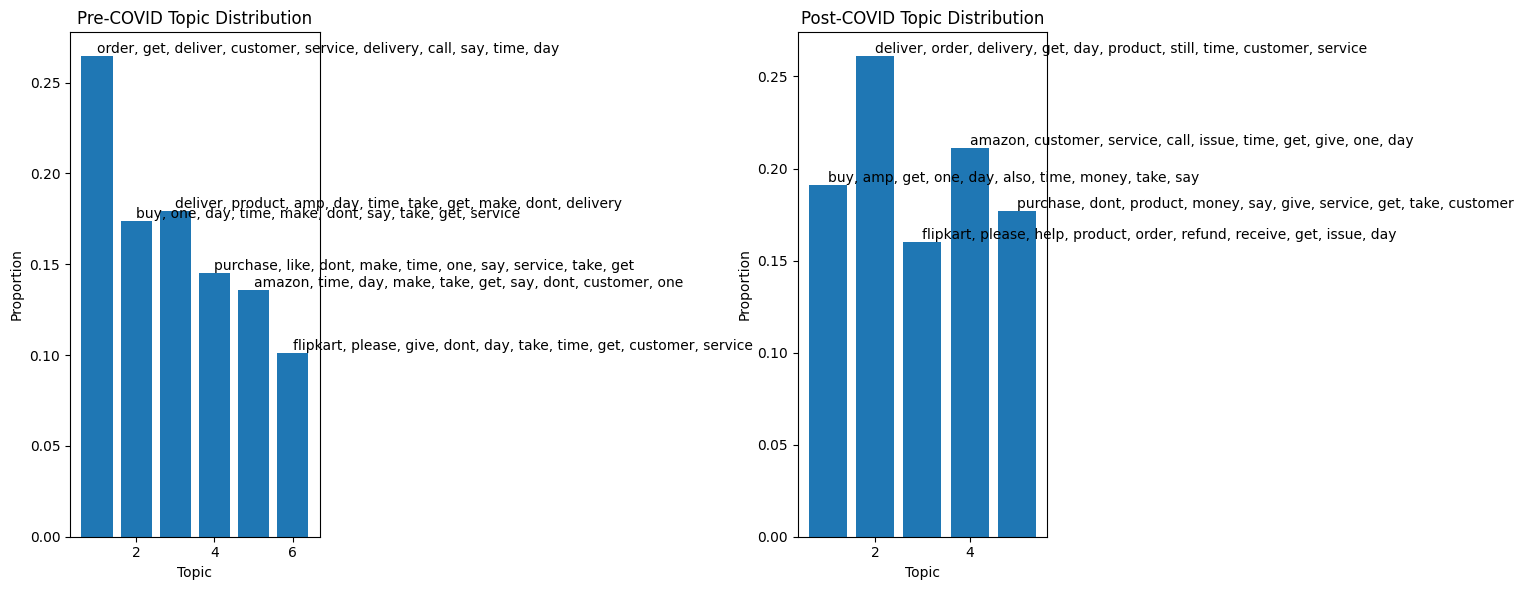

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# For pre-COVID model and corpus
plot_topic_weight(pre_covid_model, corpus_pre, 'Pre-COVID Topic Distribution', ax=axes[0])

# For post-COVID model and corpus
plot_topic_weight(post_covid_model, corpus_post, 'Post-COVID Topic Distribution', ax=axes[1])

plt.tight_layout()
plt.show()

In [57]:
def sentiment_by_topic(model, corpus, texts):
    topic_sentiment = {}
    for doc, text in zip(corpus, texts):
        doc_topics = model.get_document_topics(doc)
        sentiment = TextBlob(text).sentiment.polarity
        for topic, weight in doc_topics:
            if topic not in topic_sentiment:
                topic_sentiment[topic] = []
            topic_sentiment[topic].append(sentiment * weight)
    
    avg_sentiment = {topic: np.mean(sentiments) for topic, sentiments in topic_sentiment.items()}
    return avg_sentiment

In [85]:
pre_covid_texts = [' '.join(tokens) for tokens in df_pre['tokens']]
post_covid_texts = [' '.join(tokens) for tokens in df_post['tokens']]
pre_covid_sentiment = sentiment_by_topic(pre_covid_model, corpus_pre,pre_covid_texts )
post_covid_sentiment = sentiment_by_topic(post_covid_model, corpus_post, post_covid_texts)

In [86]:
print(pre_covid_sentiment)
print(post_covid_sentiment)

{1: 0.03683193560642418, 3: 0.031151965358606263, 2: 0.030669740719955128, 0: -0.010560054598188741, 4: 0.05308427560859688, 5: 0.014780014426972032}
{1: -0.0021190733257162855, 2: 0.0014107256221433412, 4: 0.011254307186059643, 0: 0.032922953485662904, 3: 0.00575397804169793}


### Topics and their Sentiment Scores

#### Pre-Covid:

1. **Topic 1: Customer Experience** - Words: "order, get, deliver, customer, service, delivery, call"  
   - Sentiment Score: 0.0368 (Slightly Positive)
   
2. **Topic 2: Shopping Behavior** - Words: "buy, one, day, time, make, dont, say"  
   - Sentiment Score: 0.0307 (Slightly Positive)
   
3. **Topic 3: Delivery Details** - Words: "deliver, product, amp, day, time, take, get"  
   - Sentiment Score: 0.0309 (Slightly Positive)
   
4. **Topic 4: Purchase Decision** - Words: "purchase, like, dont, make, time, one, say"  
   - Sentiment Score: 0.0530 (Positive)
   
5. **Topic 5: Amazon Specific** - Words: "amazon, time, day, make, take, get, say"  
   - Sentiment Score: 0.0147 (Slightly Positive)
   
6. **Topic 6: Flipkart Specific** - Words: "flipkart, please, give, dont, day, take, time"  
   - Sentiment Score: -0.0104 (Slightly Negative)

#### Post-Covid:

1. **Topic 1: Shopping Behavior** - Words: "buy, amp, get, one, day, also, time"  
   - Sentiment Score: -0.0023 (Almost Neutral)
   
2. **Topic 2: Order & Delivery** - Words: "deliver, order, delivery, get, day, product, still"  
   - Sentiment Score: 0.0013 (Almost Neutral)
   
3. **Topic 3: Flipkart & Issues** - Words: "flipkart, please, help, product, order, refund, receive"  
   - Sentiment Score: 0.0056 (Almost Neutral)
   
4. **Topic 4: Amazon & Customer Service** - Words: "amazon, customer, service, call, issue, time, get"  
   - Sentiment Score: 0.0114 (Slightly Positive)
   
5. **Topic 5: Purchase Concerns** - Words: "purchase, dont, product, money, say, give, service"  
   - Sentiment Score: 0.0330 (Slightly Positive)

### Interpretations:

1. **Shift in Topics**: 
   - Customer Experience and Shopping Behavior remain important in both time frames.
   - Topics are more brand-specific post-Covid, with Amazon and Flipkart each having a topic.Also Amazon and Flipkart are most talked brand among the pool of brands available
   - Pre-COVID, the focus was more on the shopping experience and customer service. Post-COVID, the focus seems to shift towards specific issues and concerns, especially with Flipkart and Amazon.
  
2. **Sentiment Changes**:
   - General sentiment was mostly positive pre-Covid, with only Flipkart-related topics showing slight negativity.
   - Post-Covid sentiment scores are generally closer to neutral. Shopping Behavior even turns almost neutral from being positive.
   - Pre-COVID sentiments were generally positive. Post-COVID, the sentiment seems to have turned more neutral or slightly negative for shopping and delivery.
   
3. **General Trends**:
   - There is a noticeable decrease in the positive sentiment for most of the topics post-Covid, indicating perhaps a more critical or demanding consumer base or challenges in service delivery during the pandemic.

4. **Consumer Concerns**:
   - Topics related to 'Purchase Concerns' and 'Customer Service' have emerged post-Covid, possibly indicating areas where consumers have growing concerns.

Increased Keywords: {'dont': 2167, 'know': 419, 'flipkart': 6771, 'list': 50, 'product': 4950, 'deliver': 3372, 'properly': 192, 'wait': 712, 'sale': -150, 'book': 415, 'device': -70, 'hard': 86, 'earn': 139, 'money': 1547, 'get': 3019, 'kind': 236, 'issue': 2565, 'seriously': 75, 'much': 212, 'understandable': -2, 'ready': 104, 'take': 1448, 'even': 959, 'bowl': -18, 'due': 533, 'away': 60, 'jerk': 4, 'pause': -6, 'well': 156, 'never': 572, 'ever': 244, 'think': 193, 'pay': 1062, 'hefty': 10, 'amount': 686, 'behave': 41, 'like': 511, 'consignment': 84, 'languish': 4, 'bengaluru': 11, 'hub': 267, 'since': 912, 'last': 926, 'hour': 157, 'amp': 214, 'intentionally': 17, 'please': 3373, 'help': 2033, 'stop': 378, 'make': 419, 'pool': -2, 'public': 58, 'bigbilliondays': -2, 'amazonseliya': 2, 'lie': 2, 'cheat': 585, 'dear': 619, 'sir': 1305, 'worth': 89, 'simply': 72, 'suppose': 94, 'sep': 57, 'hr': 79, 'action': 594, 'hey': -20, 'receive': 1743, 'see': 281, 'comment': 2, 'moron': -10, 'le

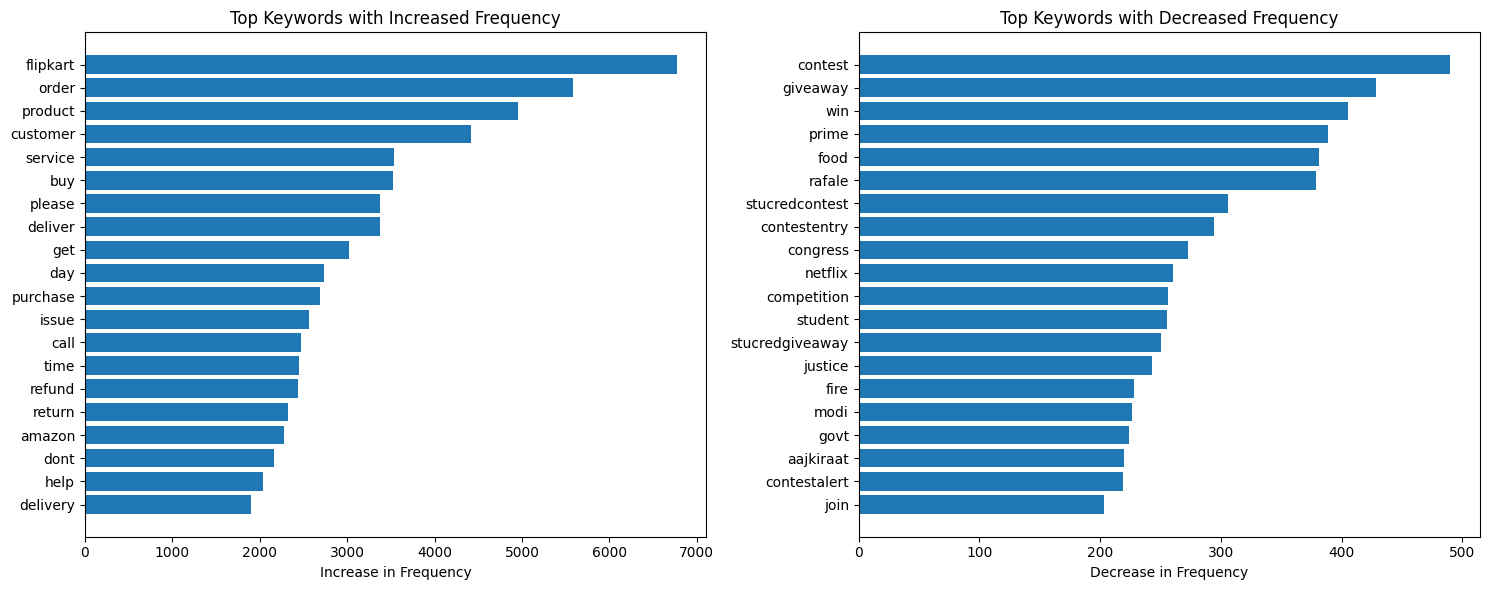

In [91]:
def keyword_analysis(texts):
    words = [word for text in texts for word in text.split()]
    return Counter(words)

pre_covid_keywords = keyword_analysis(pre_covid_texts)
post_covid_keywords = keyword_analysis(post_covid_texts)

# Find increased keywords
increased_keywords = {word: post_covid_keywords[word] - pre_covid_keywords.get(word, 0) 
                      for word in post_covid_keywords}

# Find decreased keywords
decreased_keywords = {word: pre_covid_keywords[word] - post_covid_keywords.get(word, 0) 
                      for word in pre_covid_keywords}

print("Increased Keywords:", increased_keywords)
print("Decreased Keywords:", decreased_keywords)

# Sort by frequency change and take the top 10 keywords
increased_keywords = dict(sorted(increased_keywords.items(), key=lambda x: x[1], reverse=True)[:20])
decreased_keywords = dict(sorted(decreased_keywords.items(), key=lambda x: x[1], reverse=True)[:20])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot increased keywords
axes[0].barh(range(len(increased_keywords)), list(increased_keywords.values()), align='center')
axes[0].set_yticks(range(len(increased_keywords)))
axes[0].set_yticklabels(list(increased_keywords.keys()))
axes[0].invert_yaxis()
axes[0].set_xlabel('Increase in Frequency')
axes[0].set_title('Top Keywords with Increased Frequency')

# Plot decreased keywords
axes[1].barh(range(len(decreased_keywords)), list(decreased_keywords.values()), align='center')
axes[1].set_yticks(range(len(decreased_keywords)))
axes[1].set_yticklabels(list(decreased_keywords.keys()))
axes[1].invert_yaxis()
axes[1].set_xlabel('Decrease in Frequency')
axes[1].set_title('Top Keywords with Decreased Frequency')

plt.tight_layout()
plt.show()


In [102]:
def assign_dominant_topic(model, corpus):
    dominant_topics = []
    for doc in corpus:
        doc_topics = model.get_document_topics(doc)
        dominant_topic = sorted(doc_topics, key=lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append(dominant_topic)
    return dominant_topics

# Assuming pre_covid_corpus and post_covid_corpus are your corpus data
df_pre['dominant_topic'] = assign_dominant_topic(pre_covid_model, corpus_pre)
df_post['dominant_topic'] = assign_dominant_topic(post_covid_model, corpus_post)


In [105]:
pre_covid_topic_labels = {
    0: 'Customer Experience',
    1: 'Shopping Behavior',
    2: 'Delivery Details',
    3: 'Purchase Decision',
    4: 'Amazon Specific',
    5: 'Flipkart Specific'
}

post_covid_topic_labels = {
    0: 'Shopping Behavior',
    1: 'Order & Delivery',
    2: 'Flipkart & Issues',
    3: 'Amazon & Customer Service',
    4: 'Purchase Concerns'
}

In [109]:
def plot_topic_over_time(df, title, topic_labels):
    df_grouped = df.groupby([pd.Grouper(key='created_at', freq='M'), 'dominant_topic']).size().reset_index(name='counts')
    for topic in df_grouped['dominant_topic'].unique():
        topic_time = df_grouped[df_grouped['dominant_topic'] == topic]
        plt.plot(topic_time['created_at'], topic_time['counts'], label=f"{topic_labels.get(topic, f'Topic {topic}')}")

    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Tweet Counts')
    plt.legend()
    plt.show()

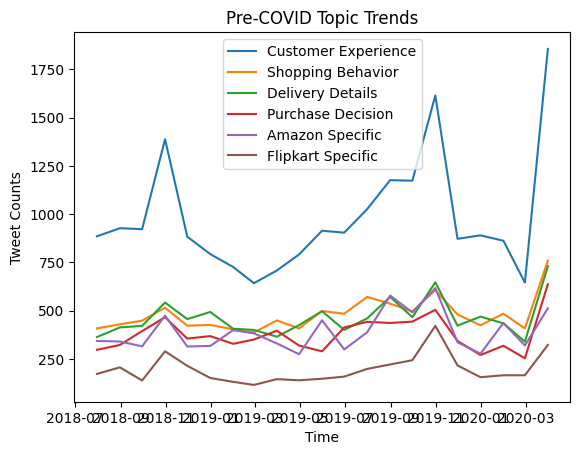

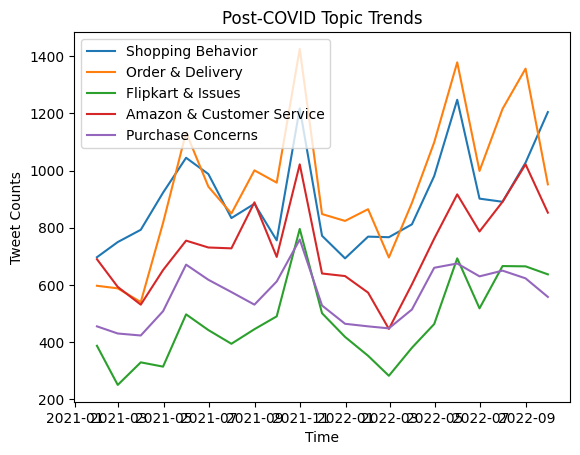

In [110]:
plot_topic_over_time(df_pre, 'Pre-COVID Topic Trends', pre_covid_topic_labels)
plot_topic_over_time(df_post, 'Post-COVID Topic Trends',post_covid_topic_labels)